# Import Packages

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/u3933826/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [1]:
from ALPackage.transformer import EMBALLayer, TransformerEncoderALLayer, TransformerEncoder
from utils import get_word_vector, get_nlp_data, set_device
from tqdm import tqdm
import time
import torch.nn as nn
import torch
import threading

ModuleNotFoundError: No module named 'torch'

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import defaultdict

# Prepare data

In [4]:
class Args:
    def __init__(self, dataset, max_len, min_len = 1):
        self.dataset = dataset
        self.class_num = None
        self.batch_size = 256        
        self.max_len = max_len
        self.min_len = min_len
        self.vocab_size = 30000
        self.pretrained_embedding = None
        self.pretrained_model = None
        self.embedding_dim = 300
        self.x_hid = 256
        self.y_hid = 128
        self.n_heads = 6       
        self.dropout = 0.3
        self.lr = 0.00025
        self.epochs = 5
        self.act = nn.Tanh()

    def get_filename(self):
        name = f"{self.dataset},{self.batch_size},{self.max_len},{self.min_len},{self.x_hid},{self.y_hid}"
        return name
    
    def set_pretrained(self, vocab, emb):
        self.pretrained_embedding = get_word_vector(vocab, emb)
        self.pretrained_model = emb

In [5]:
args = Args('ag_news', 128)
train_loader, test_loader, class_num, vocab = get_nlp_data(args)
args.class_num = class_num
args.set_pretrained(vocab, emb='glove')

|========================= Load data:ag_news ========================================================|


Found cached dataset ag_news (/home/u3933826/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)
Found cached dataset ag_news (/home/u3933826/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


|========================= Preprocessing ============================================================|
Original Data: 120000
Valid Data: 120000
total count words 102019
vocab size 30000


loading glove vocabs...: 100%|██████████| 400000/400000 [00:05<00:00, 72221.09it/s]


found 26754 words in glove


# Scale Test helper

In [6]:
class Transformer(nn.Module):
    def __init__(self, args, tr_num):
        super().__init__()
        self.seq = nn.ModuleList()
        if args.pretrained_embedding == None:
            self.seq.append(nn.Embedding(args.vocab_size, args.embedding_dim))
        else:
            self.seq.append(nn.Embedding.from_pretrained(args.pretrained_embedding, freeze=False))
        for _ in range(tr_num):        
            self.seq.append(TransformerEncoder(args.embedding_dim, args.x_hid, args.n_heads, 1, args.dropout))
        self.seq.append(nn.Sequential(
            nn.Linear(args.embedding_dim, args.class_num),
            nn.LogSoftmax(dim=1)
        ))
        self.device = ["cpu" for _ in range(len(self.seq))]

    def forward(self, x):
        mask = self.get_mask(x)

        # 1. Feed embedding layer
        x = self.seq[0](x.to(self.device[0]))

        # 2. Feed Transformer
        for i in range(1, len(self.seq)-1, 1):
            x = self.seq[i](x.to(self.device[i]), mask.to(self.device[i]))
        
        # 3. Feed fc layer
        x = x.to(self.device[-1])
        mask = mask.to(self.device[-1])
        feat = torch.sum(x*mask.unsqueeze(-1), dim=1) / torch.sum(mask, -1, keepdim=True)
        return self.seq[-1](feat)

    def get_mask(self, x):
        pad_mask = ~(x == 0)
        return pad_mask

In [7]:
class TransformerAL(nn.Module):
    def __init__(self, args, tr_num):
        super().__init__()
        self.seq = nn.ModuleList()
        self.seq.append(EMBALLayer(args.vocab_size, args.embedding_dim, args.class_num, args.y_hid, args.act, args.lr, args.pretrained_embedding))
        for _ in range(tr_num):
            self.seq.append(TransformerEncoderALLayer(args.embedding_dim, args.x_hid, args.y_hid, args.y_hid, args.act, args.lr, args.n_heads, 1, args.dropout))
        self.device = ["cpu" for i in range(len(self.seq))]

    def forward(self, x, y):
        mask = self.get_mask(x)

        # 1. Feed embedding layer
        x, y = self.seq[0](x.to(self.device[0]), y.to(self.device[0]))
        
        # 2. Feed Transformer
        for i in range(1, len(self.seq), 1):
            inputs = (x.to(self.device[i]), mask.to(self.device[i]))
            y = y.to(self.device[i])
            x, y = self.seq[i](inputs, y)

    def backward(self):
        for i in range(len(self.seq)):
            self.seq[i].backward()

    def update(self):
        for i in range(len(self.seq)):
            self.seq[i].update()

    def thread_backward_and_update(self):
        threads = []
        for i in range(len(self.seq)):
            threads.append(threading.Thread(target=self.seq[i].backward_and_update))
            threads[i].start()
        for i in range(len(self.seq)):
            threads[i].join()

    def thread_forward_backward_and_update(self, x, y):
        threads = []
        mask = self.get_mask(x)

        # 1. Feed embedding layer
        x, y = self.seq[0](x.to(self.device[0]), y.to(self.device[0]))
        threads.append(threading.Thread(target=self.seq[0].backward_and_update))
        threads[0].start()

        # 2. Feed Transformer
        for i in range(1, len(self.seq), 1):
            inputs = (x.to(self.device[i]), mask.to(self.device[i]))
            y = y.to(self.device[i])
            x, y = self.seq[i](inputs, y)
            threads.append(threading.Thread(target=self.seq[i].backward_and_update))
            threads[i].start()
        
        for i in range(len(self.seq)):
            threads[i].join()
    
    def loss(self):
        loss = {
            "enc_loss": [],
            "ae_loss": []
        }
        for i in range(len(self.seq)):
            enc_loss, ae_loss = self.seq[i].loss()
            loss['enc_loss'].append(enc_loss.item())
            loss['ae_loss'].append(ae_loss.item())
        return loss

    def inference(self, x):
        mask = self.get_mask(x)
        x = self.seq[0].inference(x.to(self.device[0]), 'f')
        for i in range(1, len(self.seq), 1):
            inputs = (x.to(self.device[i]), mask.to(self.device[i]))
            x = self.seq[i].inference(inputs, 'f')
        inputs = (x, mask.to(self.device[i]))
        x = self.seq[-1].inference(inputs, 'b')
        for i in range(len(self.seq)-1, -1, -1):
            x = x.to(self.device[i])
            x = self.seq[i].inference(x, 'h')
        return x

    def get_mask(self, x):
        pad_mask = ~(x == 0)
        return pad_mask

# Trainer

In [8]:
def Trainer(args, mode, device, tr_num):
    
    train_time = []
    
    if mode == "BP":
        model = Transformer(args, tr_num)
        set_device(model, device)
        optimizer = torch.optim.Adam(model.parameters(), args.lr)
        loss_fn = nn.NLLLoss()
        
        for epoch in range(args.epochs):
            model.train()
            torch.cuda.synchronize()
            start = time.time()
            for inputs, labels in tqdm(train_loader):            
                labels = labels.to(device[-1])
                pred = model(inputs)
                loss_fn(pred, labels).backward()
                optimizer.step()
                optimizer.zero_grad()
            torch.cuda.synchronize()
            end = time.time()
            train_time.append(end-start)
                
    elif mode == "AL":
        model = TransformerAL(args, tr_num)
        set_device(model, device)
        for epoch in range(args.epochs):
            model.train()
            torch.cuda.synchronize()
            start = time.time()
            for inputs, labels in tqdm(train_loader):
                y = torch.nn.functional.one_hot(labels, args.class_num).float()
                model.thread_forward_backward_and_update(inputs, y)
            torch.cuda.synchronize()
            end = time.time()
            train_time.append(end-start)
    
    return np.mean(train_time), np.std(train_time)     

# Scaling Test

In [10]:
def Scale():
    
    '''
    Weak: Add layers, add GPU
    x: number of layers
    y: execution time
    method: gpu_num

    1 gpu with 1x layers
    2 gpu with 2x layers
    ...
    6 gpu with 6x layers 

    ===================================

    Strong: Fix layers, add gpu
    x: number of gpu
    y: execution time
    method: number of layers

    6 layers with 1, 2, 3, 6 gpus
    12 layers with 1, 2, 3, 4, 6 gpus
    '''    
    
    gpus = {
        "1":[[0],[0,0],[0,0,0],[0,0,0,0],[0,0,0,0,0],[0,0,0,0,0,0],
             [0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0],
             [0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0]],
        "2":[[0,1],[0,0,1,1],[0,0,0,1,1,1],[0,0,0,0,1,1,1,1],[0,0,0,0,0,1,1,1,1,1],[0,0,0,0,0,0,1,1,1,1,1,1]],
        "3":[[0,1,2],[0,0,1,1,2,2],[0,0,0,1,1,1,2,2,2],[0,0,0,0,1,1,1,1,2,2,2,2]],
        "4":[[0,1,2,3],[0,0,1,1,2,2,3,3],[0,0,0,1,1,1,2,2,2,3,3,3]],
        "5":[[0,1,2,3,4],[0,0,1,1,2,2,3,3,4,4]],
        "6":[[0,1,2,3,4,5],[0,0,1,1,2,2,3,3,4,4,5,5]]
    }

    key = []
    bp = []
    al = []
    
    try:
        mode = "BP"
        for gpu, layers in gpus.items():
            for layer in layers:
                n = len(layer)
                device = ['cuda:0']
                for l in layer:
                    device.append(f"cuda:{l}")
                device.append(f"cuda:{layer[-1]}")
                mean, std = Trainer(args, mode, device, n)
                bp.append(f"{mean:.4f}±{std:.4f}")
                print(f"BP {gpu}gpu_{n}Trlayers:{mean:.4f}±{std:.4f}")
            
        mode = "AL"    
        for gpu, layers in gpus.items():
            for layer in layers:
                n = len(layer)
                device = ['cuda:0']
                for l in layer:
                    device.append(f"cuda:{l}")
                mean, std = Trainer(args, mode, device, n)
                al.append(f"{mean:.4f}±{std:.4f}")
                print(f"AL {gpu}gpu_{n}Trlayers:{mean:.4f}±{std:.4f}")

        for gpu, layers in gpus.items():
            for layer in layers:
                n = len(layer)
                key.append(f"{gpu}gpu_{n}Trlayers")

        result = {
            "key": key,
            "bp": bp,
            "al": al
        }  

        df = pd.DataFrame(result)
        df.to_csv(f"Scale.csv", index=False)
        return bp, al

    except Exception as e:
        print(e)      
        return bp, al

In [11]:
bp, al = Scale()

100%|██████████| 469/469 [00:08<00:00, 56.29it/s]


BP 1gpu_1Trlayers:8.3734±0.0970


100%|██████████| 469/469 [00:14<00:00, 32.59it/s]


BP 1gpu_2Trlayers:14.9438±0.4013


100%|██████████| 469/469 [00:20<00:00, 22.53it/s]


BP 1gpu_3Trlayers:20.8352±0.0569


100%|██████████| 469/469 [00:27<00:00, 17.05it/s]


BP 1gpu_4Trlayers:27.3430±0.1510


100%|██████████| 469/469 [00:33<00:00, 14.01it/s]


BP 1gpu_5Trlayers:33.8567±0.5492


100%|██████████| 469/469 [00:39<00:00, 11.81it/s]


BP 1gpu_6Trlayers:40.0579±0.4467


100%|██████████| 469/469 [00:45<00:00, 10.26it/s]


BP 1gpu_7Trlayers:45.9336±0.1529


100%|██████████| 469/469 [00:52<00:00,  8.91it/s]


BP 1gpu_8Trlayers:52.6002±0.2739


100%|██████████| 469/469 [00:58<00:00,  8.01it/s]


BP 1gpu_9Trlayers:58.8116±0.2049


100%|██████████| 469/469 [01:04<00:00,  7.24it/s]


BP 1gpu_10Trlayers:64.5912±0.1817


100%|██████████| 469/469 [01:10<00:00,  6.61it/s]


BP 1gpu_11Trlayers:70.7207±0.1514


100%|██████████| 469/469 [01:15<00:00,  6.18it/s]


BP 1gpu_12Trlayers:76.4952±0.3955


100%|██████████| 469/469 [00:15<00:00, 30.75it/s]


BP 2gpu_2Trlayers:15.2545±0.0994


100%|██████████| 469/469 [00:28<00:00, 16.53it/s]


BP 2gpu_4Trlayers:28.2843±0.1099


100%|██████████| 469/469 [00:40<00:00, 11.55it/s]


BP 2gpu_6Trlayers:40.7531±0.1053


100%|██████████| 469/469 [00:52<00:00,  8.88it/s]


BP 2gpu_8Trlayers:52.9547±0.0708


100%|██████████| 469/469 [01:04<00:00,  7.23it/s]


BP 2gpu_10Trlayers:64.8334±0.1736


100%|██████████| 469/469 [01:16<00:00,  6.11it/s]


BP 2gpu_12Trlayers:76.6917±0.1794


100%|██████████| 469/469 [00:23<00:00, 19.85it/s]


BP 3gpu_3Trlayers:23.5520±0.1383


100%|██████████| 469/469 [00:43<00:00, 10.83it/s]


BP 3gpu_6Trlayers:43.6421±0.2525


100%|██████████| 469/469 [01:00<00:00,  7.74it/s]


BP 3gpu_9Trlayers:60.5362±0.3050


100%|██████████| 469/469 [01:18<00:00,  6.00it/s]


BP 3gpu_12Trlayers:77.9079±0.2478


100%|██████████| 469/469 [00:31<00:00, 15.12it/s]


BP 4gpu_4Trlayers:30.6141±0.4868


100%|██████████| 469/469 [00:57<00:00,  8.20it/s]


BP 4gpu_8Trlayers:57.3711±0.1238


100%|██████████| 469/469 [01:22<00:00,  5.69it/s]


BP 4gpu_12Trlayers:82.6394±0.2389


100%|██████████| 469/469 [00:39<00:00, 11.89it/s]


BP 5gpu_5Trlayers:39.7588±0.3489


100%|██████████| 469/469 [01:12<00:00,  6.47it/s]


BP 5gpu_10Trlayers:72.3184±0.1783


100%|██████████| 469/469 [00:47<00:00,  9.98it/s]


BP 6gpu_6Trlayers:46.8407±0.1325


100%|██████████| 469/469 [01:24<00:00,  5.52it/s]


BP 6gpu_12Trlayers:86.1056±1.6430


100%|██████████| 469/469 [00:07<00:00, 66.63it/s]


AL 1gpu_1Trlayers:7.0983±0.0601


100%|██████████| 469/469 [00:12<00:00, 38.66it/s]


AL 1gpu_2Trlayers:12.1553±0.0204


100%|██████████| 469/469 [00:17<00:00, 26.81it/s]


AL 1gpu_3Trlayers:17.5187±0.0245


100%|██████████| 469/469 [00:22<00:00, 20.50it/s]


AL 1gpu_4Trlayers:22.9735±0.0578


100%|██████████| 469/469 [00:28<00:00, 16.64it/s]


AL 1gpu_5Trlayers:28.3554±0.1054


100%|██████████| 469/469 [00:33<00:00, 13.97it/s]


AL 1gpu_6Trlayers:33.7685±0.1114


100%|██████████| 469/469 [00:39<00:00, 12.02it/s]


AL 1gpu_7Trlayers:39.2112±0.1043


100%|██████████| 469/469 [00:44<00:00, 10.52it/s]


AL 1gpu_8Trlayers:44.6508±0.0663


100%|██████████| 469/469 [00:49<00:00,  9.45it/s]


AL 1gpu_9Trlayers:49.8479±0.1974


100%|██████████| 469/469 [00:55<00:00,  8.51it/s]


AL 1gpu_10Trlayers:55.2403±0.0579


100%|██████████| 469/469 [01:00<00:00,  7.70it/s]


AL 1gpu_11Trlayers:60.8152±0.0661


100%|██████████| 469/469 [01:05<00:00,  7.15it/s]


AL 1gpu_12Trlayers:66.0528±0.2424


100%|██████████| 469/469 [00:08<00:00, 52.44it/s]


AL 2gpu_2Trlayers:8.6187±0.1733


100%|██████████| 469/469 [00:19<00:00, 24.44it/s]


AL 2gpu_4Trlayers:19.1516±0.0622


100%|██████████| 469/469 [00:29<00:00, 15.70it/s]


AL 2gpu_6Trlayers:29.9998±0.2047


100%|██████████| 469/469 [00:40<00:00, 11.50it/s]


AL 2gpu_8Trlayers:40.8495±0.1800


100%|██████████| 469/469 [00:51<00:00,  9.05it/s]


AL 2gpu_10Trlayers:51.8299±0.0327


100%|██████████| 469/469 [01:02<00:00,  7.54it/s]


AL 2gpu_12Trlayers:62.5702±0.2231


100%|██████████| 469/469 [00:13<00:00, 34.89it/s]


AL 3gpu_3Trlayers:11.8783±1.0310


100%|██████████| 469/469 [00:29<00:00, 15.81it/s]


AL 3gpu_6Trlayers:29.7295±0.4925


100%|██████████| 469/469 [00:46<00:00, 10.11it/s]


AL 3gpu_9Trlayers:46.4238±0.0909


100%|██████████| 469/469 [01:02<00:00,  7.50it/s]


AL 3gpu_12Trlayers:62.8343±0.1652


100%|██████████| 469/469 [00:14<00:00, 32.26it/s]


AL 4gpu_4Trlayers:14.7134±0.1404


100%|██████████| 469/469 [00:42<00:00, 10.93it/s]


AL 4gpu_8Trlayers:42.7969±0.4148


100%|██████████| 469/469 [01:04<00:00,  7.31it/s]


AL 4gpu_12Trlayers:64.1596±0.2738


100%|██████████| 469/469 [00:21<00:00, 21.96it/s]


AL 5gpu_5Trlayers:21.4467±0.4590


100%|██████████| 469/469 [00:56<00:00,  8.29it/s]


AL 5gpu_10Trlayers:56.4686±0.2248


100%|██████████| 469/469 [00:27<00:00, 16.80it/s]


AL 6gpu_6Trlayers:26.8651±0.5387


100%|██████████| 469/469 [01:08<00:00,  6.82it/s]

AL 6gpu_12Trlayers:68.4918±0.2329


# Preview

In [2]:
def CalculateSpeedUp(time):
    speedup = []
    for t in time:
        speedup.append(time[0]/t)
    return speedup

In [10]:
def plotGraph(bp, al, title):
    
    if len(bp)==6:
        gpu = [1, 2, 3, 4, 5, 6]
        xlabel = "Number of GPUs & task size"
    else:
        gpu = [1, 2, 3, 4, 6]
        xlabel = "Number of GPUs"
    
    fig, axs = plt.subplots(2, 1, figsize=(8, 6))
    fig.suptitle(title)

    # 繪製子圖A
    axs[0].plot(gpu, bp, label="BP")
    axs[0].plot(gpu, al, label="AL")
    axs[0].set_ylabel('Execution Time')
    axs[0].set_xlabel(xlabel)
    axs[0].legend()

    # 繪製子圖B
    axs[1].plot(gpu, CalculateSpeedUp(bp), label="BP")
    axs[1].plot(gpu, CalculateSpeedUp(al), label="AL")
    axs[1].set_ylabel('Speedup')
    axs[1].set_xlabel(xlabel)
    axs[1].legend()

    # 顯示圖表
    plt.savefig(f"{title}.pdf", format="pdf")
    plt.show()   

In [4]:
def readResults(filename):
    
    df = pd.read_csv(filename)
    bp = []
    al = []
    for _, row in df.iterrows():
        bp.append(float(row["bp"].split("±")[0]))
        al.append(float(row["al"].split("±")[0]))
        
    plotGraph(bp, al, filename.split(".csv")[0])        

In [5]:
def getMean(string):
    return float(string.split("±")[0])

# WeakScale

In [11]:
def WeakScalePreview():
    '''
    Graph 1: Time/Speedup(y) with different number of layers/gpus(x)
    Data:
    (1,1),(2,2),(3,3),(4,4),(5,5),(6,6)

    Chart 1: Time/Speedup(BPvsAL) with different number of layers/gpus

    Graph 2: Different number of gpus(label), Time(y) with different number of layers(x)
    Data:
    (1,1~12)
    (2,2~12)
    (3,3~12)
    (6,6~12)
    '''

    data = pd.read_csv("Scale.csv", index_col = 0).to_dict("index")

    # graph 1 
    bp = []
    al = []
    for i in range(1,7,1):
        key = f"{i}gpu_{i}Trlayers"
        bp.append(getMean(data[key]["bp"]))
        al.append(getMean(data[key]["al"]))
    plotGraph(bp, al, "WeakScale")

    # chart 1
    bpSpeedup = CalculateSpeedUp(bp)
    alSpeedup = CalculateSpeedUp(al)
    bp = []
    al = []
    gpu = []
    speedup = []
    for i in range(1,7,1):
        key = f"{i}gpu_{i}Trlayers"
        bp.append(data[key]["bp"])
        al.append(data[key]["al"])
        gpu.append(i)
        speedup.append(getMean(data[key]["bp"]) / getMean(data[key]["al"]))
    res = {
        "Number of encoder & GPUs ":gpu,
        "BP":bp,
        "AL":al,
        "SpeedUp(BP[0] / BP[i])":bpSpeedup,
        "SpeedUp(AL[0] / AL[i])":alSpeedup,
        "SpeedUp(BP / AL)":speedup
    }
    print(pd.DataFrame(res).to_latex(index=False))

    # graph 2
    bp = defaultdict(list)
    al = defaultdict(list)
    for i in range(1,7,1):
        for j in range(i, 13, i):
            key = f"{i}gpu_{j}Trlayers"
            bp[i].append(getMean(data[key]["bp"]))
            al[i].append(getMean(data[key]["al"]))
    
    plt.plot([i for i in range(1,13,1)], bp[1], label="BP with 1GPU & task size m", marker=".")
    plt.plot([i for i in range(2,13,2)], bp[2], label="BP with 2GPU & task size 2m", marker=".")
    plt.plot([i for i in range(3,13,3)], bp[3], label="BP with 3GPU & task size 3m", marker=".")
    plt.plot([i for i in range(6,13,6)], bp[6], label="BP with 6GPU & task size 6m", marker=".")
    plt.plot([i for i in range(1,13,1)], al[1], label="AL with 1GPU & task size m", marker="X")
    plt.plot([i for i in range(2,13,2)], al[2], label="AL with 2GPU & task size 2m", marker="X")
    plt.plot([i for i in range(3,13,3)], al[3], label="AL with 3GPU & task size 3m", marker="X")
    plt.plot([i for i in range(6,13,6)], al[6], label="AL with 6GPU & task size 6m", marker="X")
    plt.ylabel('Execution Time')
    plt.xlabel('Number of Encoders')
    plt.legend()
    plt.savefig("WeakScale2.pdf", format="pdf")
    plt.show()

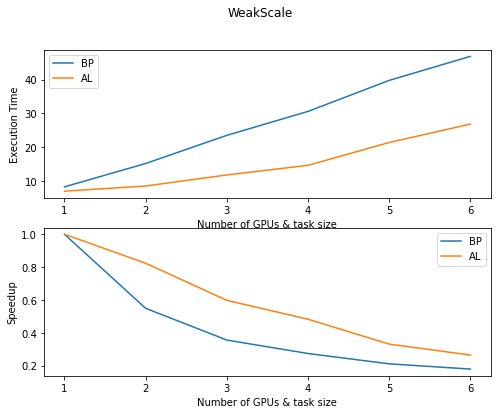

\begin{tabular}{rllrrr}
\toprule
 Number of encoder \& GPUs  &             BP &             AL &  SpeedUp(BP[0] / BP[i]) &  SpeedUp(AL[0] / AL[i]) &  SpeedUp(BP / AL) \\
\midrule
                         1 &  8.3734±0.0970 &  7.0983±0.0601 &                1.000000 &                1.000000 &          1.179635 \\
                         2 & 15.2545±0.0994 &  8.6187±0.1733 &                0.548913 &                0.823593 &          1.769930 \\
                         3 & 23.5520±0.1383 & 11.8783±1.0310 &                0.355528 &                0.597586 &          1.982775 \\
                         4 & 30.6141±0.4868 & 14.7134±0.1404 &                0.273514 &                0.482438 &          2.080695 \\
                         5 & 39.7588±0.3489 & 21.4467±0.4590 &                0.210605 &                0.330974 &          1.853842 \\
                         6 & 46.8407±0.1325 & 26.8651±0.5387 &                0.178763 &                0.264220 &          1.743552 \\
\bott

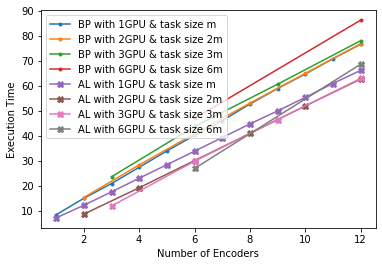

In [12]:
WeakScalePreview()

In [8]:
def StrongScalePreview():
    '''
    Graph 1: Time/Speedup(y) with different number of gpus(x)
    Data:
    (1,12),(2,12),(3,12),(4,12),(6,12)

    Chart 1: Time/Speedup(BPvsAL) with different number of gpus

    Graph 2: Different number of layers(label), Time(y) with different number of gpus(x)
    Data:
    (1,4), (2,4), (4,4)
    (1,6), (2,6), (3,6), (6,6)
    (1,8), (2,8), (4,8)
    (1,12), (2,12), (3,12), (4,12), (6,12)
    '''

    data = pd.read_csv("Scale.csv", index_col = 0).to_dict("index")

    # graph 1
    bp = []
    al = []
    for i in [1,2,3,4,6]:
        key = f"{i}gpu_12Trlayers"
        bp.append(getMean(data[key]["bp"]))
        al.append(getMean(data[key]["al"]))
    plotGraph(bp, al, "StrongScale")

    # chart 1
    bpSpeedup = CalculateSpeedUp(bp)
    alSpeedup = CalculateSpeedUp(al)
    bp = []
    al = []
    gpu = []
    speedup = []
    for i in [1,2,3,4,6]:
        key = f"{i}gpu_12Trlayers"
        bp.append(data[key]["bp"])
        al.append(data[key]["al"])
        gpu.append(i)
        speedup.append(getMean(data[key]["bp"]) / getMean(data[key]["al"]))
    res = {
        "Number of gpus":gpu,
        "BP":bp,
        "AL":al,
        "SpeedUp(BP[0] / BP[i])":bpSpeedup,
        "SpeedUp(AL[0] / AL[i])":alSpeedup,
        "SpeedUp(BP / AL)":speedup
    }
    print(pd.DataFrame(res).to_latex(index=False))

    # graph 2
    bp = defaultdict(list)
    al = defaultdict(list)
    for i in [4,6,8,12]:
        for j in [1,2,3,4,6]:
            if i % j == 0:
                key = f"{j}gpu_{i}Trlayers"
                bp[i].append(getMean(data[key]["bp"]))
                al[i].append(getMean(data[key]["al"]))
    
    plt.plot([1,2,4], bp[4], label="BP with 4Layers", marker=".")
    plt.plot([1,2,3,6], bp[6], label="BP with 6Layers", marker=".")
    plt.plot([1,2,4], bp[8], label="BP with 8Layers", marker=".")
    plt.plot([1,2,3,4,6], bp[12], label="BP with 12Layers", marker=".")
    plt.plot([1,2,4], al[4], label="AL with 4Layers", marker="X")
    plt.plot([1,2,3,6], al[6], label="AL with 6Layers", marker="X")
    plt.plot([1,2,4], al[8], label="AL with 8Layers", marker="X")
    plt.plot([1,2,3,4,6], al[12], label="AL with 12Layers", marker="X")
    plt.ylabel('Execution Time')
    plt.xlabel('Number of GPUs')
    plt.legend()
    plt.savefig("StrongScale2.pdf", format="pdf")
    plt.show()

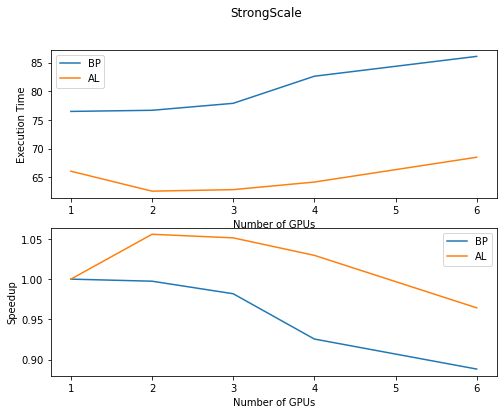

\begin{tabular}{rllrrr}
\toprule
 Number of gpus &             BP &             AL &  SpeedUp(BP[0] / BP[i]) &  SpeedUp(AL[0] / AL[i]) &  SpeedUp(BP / AL) \\
\midrule
              1 & 76.4952±0.3955 & 66.0528±0.2424 &                1.000000 &                1.000000 &          1.158092 \\
              2 & 76.6917±0.1794 & 62.5702±0.2231 &                0.997438 &                1.055659 &          1.225691 \\
              3 & 77.9079±0.2478 & 62.8343±0.1652 &                0.981867 &                1.051222 &          1.239894 \\
              4 & 82.6394±0.2389 & 64.1596±0.2738 &                0.925650 &                1.029508 &          1.288029 \\
              6 & 86.1056±1.6430 & 68.4918±0.2329 &                0.888388 &                0.964390 &          1.257167 \\
\bottomrule
\end{tabular}



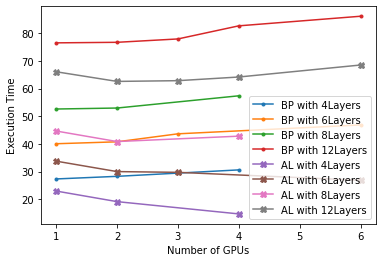

In [9]:
StrongScalePreview()